# Pytorch

In this tutorial we will use `Pytorch` to solve a simple _regression problem_.

## Summary

* Importing the libraries
* Setting the CPU/GPU to use
* Generating the dataset
* Transforming the dataset to use it in `pytorch`
* Defining the model
* Defining the `optimizer` and `loss function`
* Training and validating the model
* Taking a look at the loss function
* Testing the model in the test set

## Running options

* **On the fly:** you can easily work with this notebook in `Google Colab`: [![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/natalidesanti/pytorch_and_GNNs/blob/main/pytorch.ipynb)

* **Own computer:** otherwise you can download the notebook in your own computer and work with it in your own space. Just take care with the library dependencies. 

## 0) Importing the libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, TensorDataset
import time, sys, os
import matplotlib.pyplot as plt
import pandas as pd
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms

## 1) Setting the CPU/GPU to use

In [2]:
# Use GPU for training
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #For Linux
device = torch.device("mps") #For Macs
device

device(type='mps')

## 2) Generating the dataset

In [3]:
#Create Dataset 
def generate_data(a, b, num_examples):  
    '''
    Generate y = a x + b + noise
    '''

    x = np.random.uniform(0, 1, num_examples)
    y = a*x + b
    y += np.random.normal(0, 0.05, num_examples)

    df = pd.DataFrame(data = np.array([x, y]).T, columns = ['x', 'y'])
    
    return df

In [4]:
df = generate_data(0.5, 4.0, 2000)
df.head(5)

,x,y
0,0.713666,4.381137
1,0.575433,4.367987
2,0.439115,4.223178
3,0.558440,4.298279
4,0.499793,4.282671


Looking at the data

Text(0, 0.5, 'y')

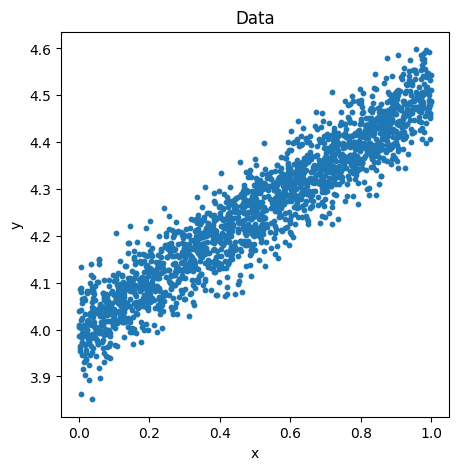

In [5]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.title('Data')
plt.scatter(df['x'], df['y'], s = 10)
plt.xlabel('x')
plt.ylabel('y')

## 3) Transforming the dataset to use it in `pytorch`

In [7]:
def transform_dataset(df, frac_train, frac_val, batch_size):
    '''
    frac_train: fraction of the dataset to use in the training
    frac_val:   fraction of the dataset to use in the validation
    batch_size: number of samples to work through before updating the internal model parameters
    '''

    #Randomizing the dataset
    df = df.sample(frac = 1)

    #Getting the training, validation, and testing sets
    x_train = np.array( [ df['x'].iloc[:int(df.shape[0]*frac_train)] ] ).T
    y_train = np.array( [ df['y'].iloc[:int(df.shape[0]*frac_train)] ] ).T

    x_val = np.array( [ df['x'].iloc[int(df.shape[0]*frac_train):int(df.shape[0]*(frac_train + frac_val))] ] ).T
    y_val = np.array( [ df['y'].iloc[int(df.shape[0]*frac_train):int(df.shape[0]*(frac_train + frac_val))] ] ).T

    x_test = np.array( [ df['x'].iloc[int(df.shape[0]*(frac_train + frac_val)):] ] ).T
    y_test = np.array( [ df['y'].iloc[int(df.shape[0]*(frac_train + frac_val)):] ] ).T

    #Getting the statistics from the training set 
    mean = np.mean(x_train, axis = 0)
    std = np.std(x_train, axis = 0)
    min = np.mean(y_train, axis = 0)
    max = np.std(y_train, axis = 0)

    #Tranforming the training set
    x_train = (x_train - mean)/std
    x_val = (x_val - mean)/std
    x_test = (x_test - mean)/std

    y_train = (y_train - min)/(max - min)
    y_val = (y_val - min)/(max - min)
    y_test = (y_test - min)/(max - min)

    #Converting to torch reshaping
    x_train = torch.from_numpy(x_train.reshape(-1, 1)).float()
    y_train = torch.from_numpy(y_train.reshape(-1, 1)).float()

    x_val = torch.from_numpy(x_val.reshape(-1, 1)).float()
    y_val = torch.from_numpy(y_val.reshape(-1, 1)).float()

    x_test = torch.from_numpy(x_test.reshape(-1, 1)).float()
    y_test = torch.from_numpy(y_test.reshape(-1, 1)).float()

    #Converting to tensor dataset
    dataset_train = TensorDataset(x_train, y_train)
    dataset_val = TensorDataset(x_val, y_val)
    dataset_test = TensorDataset(x_test, y_test)

    #Organizing in batches
    train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size)
    val_loader = DataLoader(dataset = dataset_val, batch_size = batch_size)
    test_loader = DataLoader(dataset = dataset_test, batch_size = batch_size)

    return train_loader, val_loader, test_loader, mean, std, max, min

In [8]:
train_loader, val_loader, test_loader, mean, std, max, min = transform_dataset(df, 0.8, 0.1, 100)

## 4) Defining the model

In [9]:
class model(nn.Module):
  def __init__(self):

    super(model, self).__init__() #Initiating the model

    #Defining the linear layers and activation function
    self.layer1 = nn.Linear(1, 8) 
    self.layer2 = nn.Linear(8, 16)
    self.layer3 = nn.Linear(16, 1)
    self.ReLU = nn.ReLU()

  #Forward pass
  def forward(self, x):
    '''
    Define the architecture at the same time as compute y
    '''
    x = self.ReLU(self.layer1(x))
    x = self.ReLU(self.layer2(x))
    y = self.layer3(x)
      
    return y

Instantiating the model

In [10]:
model = model().to(device)
model

model(
  (layer1): Linear(in_features=1, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (ReLU): ReLU()
)

Computing the number of parameters of the model

In [11]:
network_total_params = sum(p.numel() for p in model.parameters())

In [12]:
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 177


## 5) Defining the `optimizer` and `loss function`

* **optimizer:** algorithm that adjust the model parameters during training to minimize the loss function
* **loss function:** a mathematical function that quantifies the difference between predicted and actual values

In [13]:
optimizer = torch.optim.Adam(model.parameters())
loss_func = torch.nn.MSELoss()

## 6) Training and validating the model

In [14]:
epochs = 100 #Number of steps to train the model

lloss_train = []
lloss_val = []
for i in range(epochs):
  aux_train = 0
  model.train()  #Telling the model we are training :p
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    prediction = model(x)
    tloss = loss_func(prediction, y) 
    optimizer.zero_grad() #set the gradients to zero before starting to do backpropagation (i.e., updating the weights and biases)
    tloss.backward() #calculate the gradient during the backward pass in the neural network       
    optimizer.step() #performs a single optimization step (parameter update)
    aux_train += tloss.item()
  lloss_train.append( aux_train/len(train_loader) )     
  if i % 10 == 0:
    print(f"Epoch {i} | Train Loss {aux_train/len(train_loader)}")

  aux_val = 0
  model.eval() #Telling the model we are testing :p
  for x, y in val_loader:
    x = x.to(device)
    y = y.to(device)
    prediction = model(x)
    vloss = loss_func(prediction, y) 
    aux_val += vloss.item()
  lloss_val.append( aux_val/len(val_loader) )
  if i % 10 == 0:
    print(f"Epoch {i} | Val Loss {aux_val/len(val_loader)}")

Epoch 0 | Train Loss 0.00560496530670207
Epoch 0 | Val Loss 0.001794789219275117
Epoch 10 | Train Loss 0.00015768708362884354
Epoch 10 | Val Loss 0.00018073552200803533
Epoch 20 | Train Loss 0.0001500800613030151
Epoch 20 | Val Loss 0.00017401443619746715
Epoch 30 | Train Loss 0.0001483586206632026
Epoch 30 | Val Loss 0.0001712034354568459
Epoch 40 | Train Loss 0.00014737359879291034
Epoch 40 | Val Loss 0.00016771195078035817
Epoch 50 | Train Loss 0.00014632895044996985
Epoch 50 | Val Loss 0.0001662970389588736
Epoch 60 | Train Loss 0.00014572144891644712
Epoch 60 | Val Loss 0.0001659112749621272
Epoch 70 | Train Loss 0.00014544608484357013
Epoch 70 | Val Loss 0.00016578110080445185
Epoch 80 | Train Loss 0.00014536928665620508
Epoch 80 | Val Loss 0.00016577680798945948
Epoch 90 | Train Loss 0.0001453943868909846
Epoch 90 | Val Loss 0.0001657791217439808


## 7) Taking a look at the loss function

Here we can see if our model is **overfitting**, **underfitting** or doing well

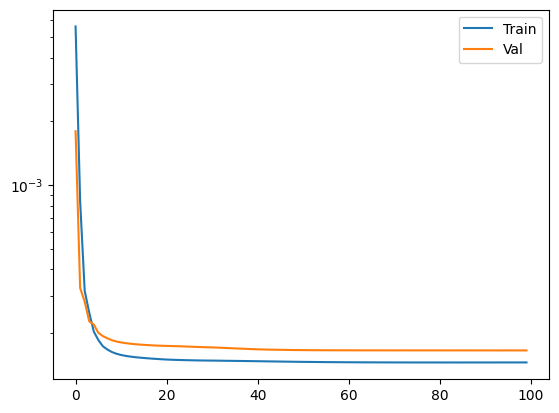

In [15]:
plt.figure(dpi = 100)
plt.plot(lloss_train, label = 'Train')
plt.plot(lloss_val, label = 'Val')
plt.legend()
plt.yscale('log')

## 8) Testing the model in the test set

In [18]:
lloss_test = []
preds = []
yss = []
for x, y in test_loader:
  out = model( x.to(device))
  preds.append( out.detach().cpu().numpy() )
  yss.append( np.array( y ) )
  loss = loss_func(out, torch.from_numpy( np.array(y[:, 0]) ).float().to(device))
lloss_test.append( loss.data.cpu().numpy() )

Arranging the batches results

In [19]:
new_preds = np.concatenate( [preds[i] for i in range(len(preds))])
new_yss = np.concatenate( [yss[i] for i in range(len(yss))])
new_preds.shape, new_yss.shape

((200, 1), (200, 1))

In [20]:
df = pd.DataFrame()

df["y_truth"] = new_yss[:, 0]*std + mean
df["y_pred"] = new_preds[:, 0]*std + mean

### 8.1) Computing the MSE for the test set

In [21]:
loss_test = np.mean(lloss_test)
loss_test

0.0025584216

### 8.2) Looking at the predictions for the test set

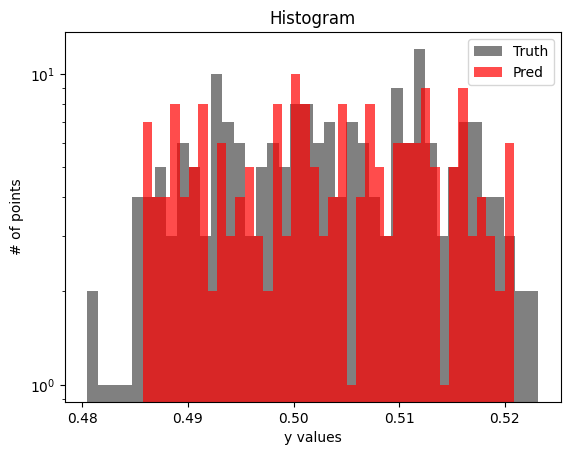

In [27]:
plt.figure(dpi = 100)
plt.title('Histogram')
plt.hist(df["y_truth"], bins = 40, label = 'Truth', color = "gray")
plt.hist(df["y_pred"], bins = 40, label = 'Pred', alpha = 0.7, color = "r")
plt.ylabel('# of points')
plt.xlabel('y values')
plt.legend()
plt.yscale('log')

Text(0.5, 0, 'Truth')

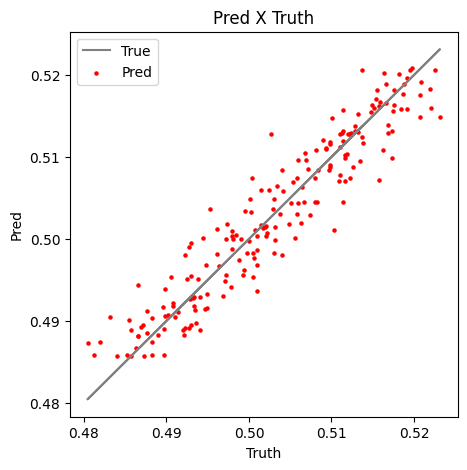

In [25]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.title('Pred X Truth')
plt.plot(df["y_truth"], df["y_truth"], color = 'gray', label = 'True')
plt.scatter(df["y_truth"], df["y_pred"], c = 'r', s = 5, label = 'Pred')
plt.legend()
plt.ylabel('Pred')
plt.xlabel('Truth')